Model Training Notebook

Random Forest Classifier Training

In [14]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid, 
                            n_iter=20, cv=3, verbose=1, n_jobs=-1)
search.fit(X_train, y_train)
print("Best Accuracy:", search.best_score_)
print("Best Parameters:", search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Accuracy: 0.5814814814814815
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30, 'bootstrap': True}


Training:  47%|████▋     | 943/2000 [14:18<16:02,  1.10it/s]


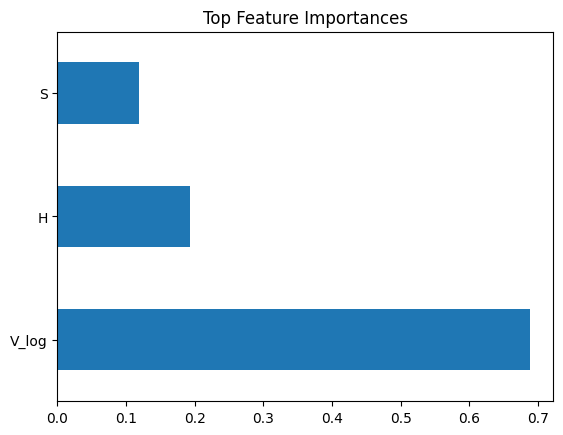

In [16]:
import matplotlib.pyplot as plt

feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp.nlargest(20).plot(kind='barh')
plt.title("Top Feature Importances")
plt.show()


In [17]:
X_train_selected = X_train[['V_log', 'H']]
X_test_selected = X_test[['V_log', 'H']]

model = RandomForestClassifier(**search.best_params_, random_state=42)
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.42      0.45      0.43        11
           1       0.85      0.92      0.88        12
           2       0.40      0.38      0.39        16
           3       0.18      0.27      0.21        11
           4       0.36      0.22      0.28        18

    accuracy                           0.43        68
   macro avg       0.44      0.45      0.44        68
weighted avg       0.44      0.43      0.42        68



In [18]:
print(y.value_counts())


M
0    71
1    70
2    66
3    66
4    65
Name: count, dtype: int64


In [11]:
import pandas as pd
import time
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tqdm.auto import tqdm

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameters
n_trees = 2500

# Use warm_start=True to fit incrementally
model = RandomForestClassifier(n_estimators=1, warm_start=True, random_state=42)

start_time = time.time()
with tqdm(total=n_trees, desc="Training RF Trees") as pbar:
    for i in range(1, n_trees + 1):
        model.set_params(n_estimators=i)
        model.fit(X_train, y_train)
        pbar.update(1)
end_time = time.time()

# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ RandomForest Accuracy: {accuracy:.4f}")
print(f"🕒 Training Time: {end_time - start_time:.2f} seconds")
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(model, "randomforest_model.pkl")
































































Training RF Trees: 100%|██████████| 2500/2500 [00:06<00:00, 397.42it/s]


✅ RandomForest Accuracy: 0.5147
🕒 Training Time: 6.29 seconds
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        11
           1       0.79      0.92      0.85        12
           2       0.40      0.25      0.31        16
           3       0.40      0.55      0.46        11
           4       0.31      0.22      0.26        18

    accuracy                           0.51        68
   macro avg       0.50      0.57      0.52        68
weighted avg       0.48      0.51      0.48        68



Training:   0%|          | 0/2000 [02:27<?, ?it/s]


['randomforest_model.pkl']

In [21]:
import pandas as pd
import time
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tqdm.auto import tqdm

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Adjusting target as M - 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier with the specified parameters
model = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features=None,
    max_depth=30,
    bootstrap=True,
    random_state=42
)

# Train the model
start_time = time.time()
model.fit(X_train, y_train)

end_time = time.time()

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ RandomForest Accuracy: {accuracy:.4f}")
print(f"🕒 Training Time: {end_time - start_time:.2f} seconds")
print(classification_report(y_test, y_pred))

# Save the trained model to a file
joblib.dump(model, "randomforest_model.pkl")


✅ RandomForest Accuracy: 0.5588
🕒 Training Time: 0.10 seconds
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.92      0.92      0.92        12
           2       0.62      0.50      0.55        16
           3       0.28      0.45      0.34        11
           4       0.50      0.39      0.44        18

    accuracy                           0.56        68
   macro avg       0.59      0.58      0.58        68
weighted avg       0.59      0.56      0.57        68



['randomforest_model.pkl']

In [1]:
import pandas as pd
import time
import joblib
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Adjusting target as M - 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Objective function to optimize hyperparameters
def objective(trial):
    # Suggest hyperparameters using optuna
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 10, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    
    # Removing 'auto' and allowing only valid options for max_features
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Initialize the RandomForest model with suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42
    )

    # Fit the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study to maximize accuracy
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)  # You can adjust n_trials for more trials

# Output the best hyperparameters and best accuracy
print(f"Best Hyperparameters: {study.best_params}")
print(f"Best Accuracy: {study.best_value:.4f}")

# Train the final model using the best hyperparameters
best_params = study.best_params
final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Final RandomForest Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Save the final model
joblib.dump(final_model, "best_randomforest_model_optuna.pkl")


/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-13 07:25:20,760] A new study created in memory with name: no-name-8e32dea8-68d7-4739-80ec-14586ea6a0dc
[I 2025-04-13 07:25:20,963] Trial 0 finished with value: 0.39705882352941174 and parameters: {'n_estimators': 282, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.39705882352941174.
[I 2025-04-13 07:25:21,347] Trial 1 finished with value: 0.5441176470588235 and parameters: {'n_estimators': 422, 'max_depth': 34, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.5441176470588235.
[I 2025-04-13 07:25:21,529] Trial 2 finished with value: 0.4411764705882353

Best Hyperparameters: {'n_estimators': 86, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}
Best Accuracy: 0.6029
✅ Final RandomForest Accuracy: 0.6029
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.64      0.58        11
           1       1.00      0.92      0.96        12
           2       0.69      0.56      0.62        16
           3       0.35      0.55      0.43        11
           4       0.57      0.44      0.50        18

    accuracy                           0.60        68
   macro avg       0.63      0.62      0.62        68
weighted avg       0.63      0.60      0.61        68



['best_randomforest_model_optuna.pkl']

XGBoost Model

In [8]:
import pandas as pd
import time
import joblib
import optuna
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Adjusting target as M - 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Objective function to optimize hyperparameters
def objective(trial):
    # Suggest hyperparameters using optuna
    n_estimators = trial.suggest_int("n_estimators", 75, 500)
    max_depth = trial.suggest_int("max_depth", 4, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.3)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    gamma = trial.suggest_float("gamma", 0.0, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.3, 1.0)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)

    # Initialize the XGBoost model with suggested hyperparameters
    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        gamma=gamma,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        random_state=42
    )

    # Fit the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study to maximize accuracy
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)  # You can adjust n_trials for more trials

# Output the best hyperparameters and best accuracy
print(f"Best Hyperparameters: {study.best_params}")
print(f"Best Accuracy: {study.best_value:.4f}")

# Train the final model using the best hyperparameters
best_params = study.best_params
final_model = XGBClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Final XGBoost Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Save the final model
joblib.dump(final_model, "best_xgboost_model_optuna.pkl")


[I 2025-04-13 07:33:27,274] A new study created in memory with name: no-name-b357ad06-315e-4d7f-8273-251b7e001e39
[I 2025-04-13 07:33:27,427] Trial 0 finished with value: 0.4117647058823529 and parameters: {'n_estimators': 485, 'max_depth': 10, 'learning_rate': 0.2732615008010978, 'min_child_weight': 8, 'gamma': 0.42789863834553776, 'colsample_bytree': 0.41655048631047076, 'subsample': 0.503749879952039}. Best is trial 0 with value: 0.4117647058823529.
[I 2025-04-13 07:33:27,619] Trial 1 finished with value: 0.4264705882352941 and parameters: {'n_estimators': 341, 'max_depth': 6, 'learning_rate': 0.1267424631613009, 'min_child_weight': 1, 'gamma': 0.04256904419194141, 'colsample_bytree': 0.39202379351357525, 'subsample': 0.8566195244330396}. Best is trial 1 with value: 0.4264705882352941.
[I 2025-04-13 07:33:27,744] Trial 2 finished with value: 0.4852941176470588 and parameters: {'n_estimators': 320, 'max_depth': 5, 'learning_rate': 0.06200442600170235, 'min_child_weight': 7, 'gamma': 

Best Hyperparameters: {'n_estimators': 248, 'max_depth': 7, 'learning_rate': 0.20710492020026877, 'min_child_weight': 8, 'gamma': 0.0682962176965653, 'colsample_bytree': 0.8501795982926942, 'subsample': 0.7640401717696358}
Best Accuracy: 0.6029
✅ Final XGBoost Accuracy: 0.6029
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.79      0.92      0.85        12
           2       0.59      0.62      0.61        16
           3       0.38      0.45      0.42        11
           4       0.50      0.33      0.40        18

    accuracy                           0.60        68
   macro avg       0.60      0.63      0.61        68
weighted avg       0.59      0.60      0.59        68



['best_xgboost_model_optuna.pkl']

In [ ]:
import pandas as pd
import time
import joblib
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Adjusting target as M - 1, assuming it's continuous now

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Objective function to optimize hyperparameters
def objective(trial):
    # Suggest hyperparameters using optuna
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 10, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    
    # Removing 'auto' and allowing only valid options for max_features
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Initialize the RandomForest model with suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42
    )

    # Fit the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # You can use different metrics for regression: here we use Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    return mse  # Optuna minimizes the objective, so return MSE (lower is better)

# Create a study to minimize MSE
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=150)  # You can adjust n_trials for more trials

# Output the best hyperparameters and best MSE
print(f"Best Hyperparameters: {study.best_params}")
print(f"Best MSE: {study.best_value:.4f}")

# Train the final model using the best hyperparameters
best_params = study.best_params
final_model = RandomForestRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Final RandomForest Regressor MSE: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

# Save the final model
joblib.dump(final_model, "best_randomforest_regressor_optuna.pkl")


[I 2025-04-13 07:29:26,319] A new study created in memory with name: no-name-1ac9c069-f83c-43ce-a702-a9807edad797
[I 2025-04-13 07:29:26,433] Trial 0 finished with value: 1.6985083101599823 and parameters: {'n_estimators': 158, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 1.6985083101599823.


[I 2025-04-13 07:29:26,717] Trial 1 finished with value: 1.7296376466465755 and parameters: {'n_estimators': 416, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 1.6985083101599823.
[I 2025-04-13 07:29:26,802] Trial 2 finished with value: 1.5767562004868199 and parameters: {'n_estimators': 151, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 1.5767562004868199.
[I 2025-04-13 07:29:26,926] Trial 3 finished with value: 1.7232355273917417 and parameters: {'n_estimators': 168, 'max_depth': 40, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 1.5767562004868199.
[I 2025-04-13 07:29:27,027] Trial 4 finished with value: 1.7624193048784171 and parameters: {'n_estimators': 192, 'max_depth': 38, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_feat

Best Hyperparameters: {'n_estimators': 62, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}
Best MSE: 1.2902
✅ Final RandomForest Regressor MSE: 1.2902
R-squared: 0.3573


['best_randomforest_regressor_optuna.pkl']

Gradient Boosting

In [1]:
import pandas as pd
import joblib
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Objective function for Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20)
    }

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", GradientBoostingClassifier(**params, random_state=42))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best model
print("✅ Best Accuracy:", study.best_value)
print("📊 Best Hyperparameters:", study.best_params)

# Train best model
best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", GradientBoostingClassifier(**study.best_params, random_state=42))
])
best_model.fit(X_train, y_train)

# Final evaluation
y_pred = best_model.predict(X_test)
print(f"\n🎯 Final Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(best_model, "gradientboosting_model_optuna.pkl")


/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-14 17:15:30,352] A new study created in memory with name: no-name-e3c238de-315b-4964-8598-1bd9bd536552
[I 2025-04-14 17:15:40,728] Trial 0 finished with value: 0.6029411764705882 and parameters: {'n_estimators': 2030, 'learning_rate': 0.0034292714622412646, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.6029411764705882.
[I 2025-04-14 17:15:44,320] Trial 1 finished with value: 0.5588235294117647 and parameters: {'n_estimators': 982, 'learning_rate': 0.0075593043941482516, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.6029411764705882.
[I 2025-04-14 17:15:51,642] Trial 2 finished with value: 0.5 and parameters: {'n

✅ Best Accuracy: 0.6176470588235294
📊 Best Hyperparameters: {'n_estimators': 2464, 'learning_rate': 0.10416790551323693, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 16}

🎯 Final Accuracy: 0.6176
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.92      0.92      0.92        12
           2       0.62      0.62      0.62        16
           3       0.33      0.55      0.41        11
           4       0.58      0.39      0.47        18

    accuracy                           0.62        68
   macro avg       0.65      0.64      0.64        68
weighted avg       0.65      0.62      0.62        68



['gradientboosting_model_optuna.pkl']


🧾 Confusion Matrix:
[[ 8  0  1  1  1]
 [ 0 11  0  1  0]
 [ 1  0 10  4  1]
 [ 0  1  1  6  3]
 [ 1  0  4  6  7]]


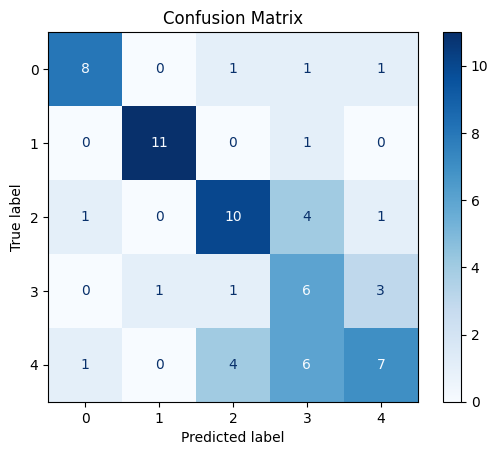

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\n🧾 Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


Xgboost Model

[I 2025-04-14 17:29:24,166] A new study created in memory with name: no-name-e9891562-f9ce-400c-87a2-c2e3c07c6b45
/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:29:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-04-14 17:29:24,254] Trial 0 finished with value: 0.47058823529411764 and parameters: {'n_estimators': 149, 'max_depth': 9, 'learning_rate': 0.24002561054956761, 'subsample': 0.880917192256741, 'colsample_bytree': 0.9786018320444773, 'gamma': 0.30410467232642846}. Best is trial 0 with value: 0.47058823529411764.
/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:29:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-04-14 17:29:24,479] Trial 1 finished with value: 0.47058823


✅ Accuracy: 0.5294

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.92      0.92      0.92        12
           2       0.50      0.50      0.50        16
           3       0.25      0.36      0.30        11
           4       0.45      0.28      0.34        18

    accuracy                           0.53        68
   macro avg       0.55      0.56      0.54        68
weighted avg       0.54      0.53      0.53        68



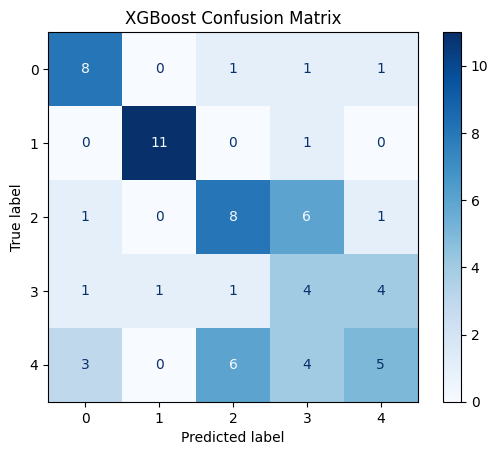

['xgboost_optuna_model.pkl']

In [3]:
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna tuning function
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "mlogloss"
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Train best model
best_model = XGBClassifier(**study.best_params, random_state=42, use_label_encoder=False, eval_metric="mlogloss")
best_model.fit(X_train, y_train)

# Evaluate
y_pred = best_model.predict(X_test)
print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("XGBoost Confusion Matrix")
plt.show()

# Optional: Save model
import joblib
joblib.dump(best_model, "xgboost_optuna_model.pkl")


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import joblib

# Load dataset
print("Loading and preparing data...")
df = pd.read_csv("transformed_land_mines.csv")
X = df.drop(columns=["M", "V"])  # Assuming M is the target and V is excluded
y = df["M"] - 1  # Adjusting to 0-based indexing if needed

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for later use
joblib.dump(scaler, "mine_detection_scaler.pkl")

#######################################
# Part 1: Voting Classifier Approach #
#######################################

def voting_classifier():
    print("\n" + "="*50)
    print("VOTING CLASSIFIER IMPLEMENTATION")
    print("="*50)
    
    # Define base models
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    svm = SVC(probability=True, random_state=42)
    
    # Create voting classifier
    voting_clf = VotingClassifier(
        estimators=[
            ('rf', rf),
            ('xgb', xgb),
            ('svm', svm)
        ],
        voting='soft'  # 'soft' uses predicted probabilities
    )
    
    print("Training base models and voting classifier...")
    
    # Train and evaluate individual models for comparison
    base_models = {
        "Random Forest": rf,
        "XGBoost": xgb,
        "SVM": svm
    }
    
    for name, model in base_models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {accuracy:.4f}")
    
    # Train and evaluate voting classifier
    voting_clf.fit(X_train_scaled, y_train)
    y_pred_vote = voting_clf.predict(X_test_scaled)
    vote_accuracy = accuracy_score(y_test, y_pred_vote)
    
    print(f"\nVoting Classifier Accuracy: {vote_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_vote))
    
    # Confusion matrix for voting classifier
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred_vote)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Voting Classifier Confusion Matrix")
    plt.savefig("voting_classifier_confusion_matrix.png")
    plt.close()
    
    # Save the model
    joblib.dump(voting_clf, "voting_classifier_model.pkl")
    
    return voting_clf

#######################################
# Part 2: Stacking Classifier Approach #
#######################################

def stacking_classifier():
    print("\n" + "="*50)
    print("STACKING CLASSIFIER IMPLEMENTATION")
    print("="*50)
    
    # Define base estimators
    estimators = [
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, 
                              use_label_encoder=False, eval_metric='mlogloss')),
        ('svm', SVC(probability=True, random_state=42))
    ]
    
    # Define meta-learner
    meta_learner = LogisticRegression(max_iter=1000, random_state=42)
    
    # Create and configure the stacking classifier
    stack_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_learner,
        cv=5,  # 5-fold cross-validation for base estimators
        stack_method='auto',  # auto uses 'predict_proba' when available
        n_jobs=-1  # Use all available processors
    )
    
    print("Training stacking classifier (this may take some time)...")
    
    # Train and evaluate stacking classifier
    stack_clf.fit(X_train_scaled, y_train)
    y_pred_stack = stack_clf.predict(X_test_scaled)
    stack_accuracy = accuracy_score(y_test, y_pred_stack)
    
    print(f"\nStacking Classifier Accuracy: {stack_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_stack))
    
    # Confusion matrix for stacking classifier
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred_stack)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Stacking Classifier Confusion Matrix")
    plt.savefig("stacking_classifier_confusion_matrix.png")
    plt.close()
    
    # Save the model
    joblib.dump(stack_clf, "stacking_classifier_model.pkl")
    
    return stack_clf

#######################################
# Advanced: Optimized Stacking with Grid Search #
#######################################

def optimized_stacking(perform_grid_search=True):
    print("\n" + "="*50)
    print("OPTIMIZED STACKING CLASSIFIER")
    print("="*50)
    
    # Create base estimators with placeholders for optimal parameters
    rf = RandomForestClassifier(random_state=42)
    xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    svm = SVC(probability=True, random_state=42)
    
    # Define parameter grids for quick optimization
    # For a full optimization, expand these grids
    if perform_grid_search:
        print("Performing grid search for base models (this will take time)...")
        
        # Random Forest optimization
        rf_param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
        rf_grid = GridSearchCV(rf, rf_param_grid, cv=3, n_jobs=-1, verbose=1)
        rf_grid.fit(X_train_scaled, y_train)
        rf_best = rf_grid.best_estimator_
        print(f"Best RF parameters: {rf_grid.best_params_}")
        
        # XGBoost optimization
        xgb_param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6]
        }
        xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=3, n_jobs=-1, verbose=1)
        xgb_grid.fit(X_train_scaled, y_train)
        xgb_best = xgb_grid.best_estimator_
        print(f"Best XGB parameters: {xgb_grid.best_params_}")
        
        # SVM optimization
        svm_param_grid = {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf', 'poly']
        }
        svm_grid = GridSearchCV(svm, svm_param_grid, cv=3, n_jobs=-1, verbose=1)
        svm_grid.fit(X_train_scaled, y_train)
        svm_best = svm_grid.best_estimator_
        print(f"Best SVM parameters: {svm_grid.best_params_}")
    else:
        # Use reasonable defaults if not performing grid search
        rf_best = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=2, random_state=42)
        xgb_best = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42, 
                                use_label_encoder=False, eval_metric='mlogloss')
        svm_best = SVC(C=1, gamma='scale', kernel='rbf', probability=True, random_state=42)
        
        # Fit the models
        print("Training base models with default hyperparameters...")
        rf_best.fit(X_train_scaled, y_train)
        xgb_best.fit(X_train_scaled, y_train)
        svm_best.fit(X_train_scaled, y_train)
    
    # Create optimized stack with best models
    estimators = [
        ('rf_best', rf_best),
        ('xgb_best', xgb_best),
        ('svm_best', svm_best)
    ]
    
    # Add another layer of models for more complex stacking
    # This additional layer helps with learning different aspects of the data
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    meta_features = np.zeros((X_train_scaled.shape[0], len(estimators)))
    
    print("Generating meta-features for stacking...")
    for i, (name, model) in enumerate(estimators):
        # Generate out-of-fold predictions for training meta-learner
        for train_idx, val_idx in kf.split(X_train_scaled, y_train):
            # Train on each fold
            model.fit(X_train_scaled[train_idx], y_train.iloc[train_idx])
            # Predict probabilities for validation fold
            if hasattr(model, "predict_proba"):
                fold_preds = model.predict_proba(X_train_scaled[val_idx])
                # Use the probability of the positive class
                meta_features[val_idx, i] = np.argmax(fold_preds, axis=1)
            else:
                meta_features[val_idx, i] = model.predict(X_train_scaled[val_idx])
    
    # Create final stacking classifier with optimized base models
    optimized_stack = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=1000, C=1.0, random_state=42),
        cv=5,
        stack_method='auto',
        n_jobs=-1
    )
    
    print("Training optimized stacking classifier...")
    optimized_stack.fit(X_train_scaled, y_train)
    y_pred_opt = optimized_stack.predict(X_test_scaled)
    opt_accuracy = accuracy_score(y_test, y_pred_opt)
    
    print(f"\nOptimized Stacking Classifier Accuracy: {opt_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_opt))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred_opt)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Optimized Stacking Classifier Confusion Matrix")
    plt.savefig("optimized_stacking_confusion_matrix.png")
    plt.close()
    
    # Feature importance analysis (if possible)
    if hasattr(rf_best, 'feature_importances_'):
        print("\nFeature Importance from Random Forest:")
        feature_names = X.columns
        importances = rf_best.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title('Feature Importance')
        plt.bar(range(X.shape[1]), importances[indices], align='center')
        plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.savefig("feature_importance.png")
        plt.close()
        
        for i in range(min(10, X.shape[1])):
            print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
    
    # Save the model
    joblib.dump(optimized_stack, "optimized_stacking_model.pkl")
    
    return optimized_stack

#######################################
# Model Comparison and Analysis #
#######################################

def compare_models(voting_clf, stack_clf, opt_stack_clf=None):
    print("\n" + "="*50)
    print("MODEL COMPARISON")
    print("="*50)
    
    models = {
        "Voting Classifier": voting_clf,
        "Stacking Classifier": stack_clf
    }
    
    if opt_stack_clf is not None:
        models["Optimized Stacking"] = opt_stack_clf
    
    # Compare model performance
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
        results[name] = {
            "Test Accuracy": accuracy,
            "CV Mean": cv_scores.mean(),
            "CV Std": cv_scores.std()
        }
    
    # Display results as table
    print("\nModel Performance Comparison:")
    print(f"{'Model':<20} {'Test Accuracy':<15} {'CV Mean':<15} {'CV Std':<15}")
    print("-" * 65)
    for name, metrics in results.items():
        print(f"{name:<20} {metrics['Test Accuracy']:<15.4f} {metrics['CV Mean']:<15.4f} {metrics['CV Std']:<15.4f}")
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    
    # Bar plot for test accuracy
    names = list(results.keys())
    test_acc = [metrics['Test Accuracy'] for metrics in results.values()]
    cv_means = [metrics['CV Mean'] for metrics in results.values()]
    
    x = np.arange(len(names))
    width = 0.35
    
    plt.bar(x - width/2, test_acc, width, label='Test Accuracy')
    plt.bar(x + width/2, cv_means, width, label='CV Mean Accuracy')
    
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Model Comparison')
    plt.xticks(x, names)
    plt.legend()
    plt.tight_layout()
    plt.savefig("model_comparison.png")
    plt.close()
    
    print("\nModel comparison chart saved as 'model_comparison.png'")
    
    # Additional analysis: per-class performance
    print("\nPer-class performance of best model:")
    best_model_name = max(results, key=lambda k: results[k]['Test Accuracy'])
    best_model = models[best_model_name]
    y_pred = best_model.predict(X_test_scaled)
    
    print(f"Best model: {best_model_name}")
    print(classification_report(y_test, y_pred))

#######################################
# Main Execution #
#######################################

if __name__ == "__main__":
    print("="*50)
    print("LAND MINE DETECTION: ENSEMBLE METHODS")
    print("="*50)
    
    # Run voting classifier
    voting_model = voting_classifier()
    
    # Run stacking classifier
    stacking_model = stacking_classifier()
    
    # Optional: Run optimized stacking
    # Set perform_grid_search=False for faster execution without grid search
    optimized_model = optimized_stacking(perform_grid_search=False)
    
    # Compare all models
    compare_models(voting_model, stacking_model, optimized_model)
    
    print("\nAll models trained and saved successfully!")
    print("\nSaved models:")
    print("- voting_classifier_model.pkl")
    print("- stacking_classifier_model.pkl") 
    print("- optimized_stacking_model.pkl")

Loading and preparing data...
LAND MINE DETECTION: ENSEMBLE METHODS

VOTING CLASSIFIER IMPLEMENTATION
Training base models and voting classifier...
Random Forest Accuracy: 0.5147


/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:47:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.5147
SVM Accuracy: 0.4412


/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:47:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Voting Classifier Accuracy: 0.4853

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.92      0.92      0.92        12
           2       0.36      0.31      0.33        16
           3       0.26      0.45      0.33        11
           4       0.40      0.22      0.29        18

    accuracy                           0.49        68
   macro avg       0.51      0.53      0.51        68
weighted avg       0.49      0.49      0.48        68


STACKING CLASSIFIER IMPLEMENTATION
Training stacking classifier (this may take some time)...


/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:47:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[17:47:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[17:47:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[17:47:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[17:47:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[17:47:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Stacking Classifier Accuracy: 0.5588

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.85      0.92      0.88        12
           2       0.47      0.50      0.48        16
           3       0.33      0.45      0.38        11
           4       0.55      0.33      0.41        18

    accuracy                           0.56        68
   macro avg       0.57      0.59      0.57        68
weighted avg       0.57      0.56      0.55        68


OPTIMIZED STACKING CLASSIFIER
Training base models with default hyperparameters...


/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:47:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Generating meta-features for stacking...


/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:47:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:47:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:47:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:47:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tea

Training optimized stacking classifier...


/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:47:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[17:47:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[17:47:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[17:47:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[17:47:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[17:47:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Optimized Stacking Classifier Accuracy: 0.5735

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.85      0.92      0.88        12
           2       0.47      0.50      0.48        16
           3       0.36      0.45      0.40        11
           4       0.60      0.33      0.43        18

    accuracy                           0.57        68
   macro avg       0.58      0.60      0.58        68
weighted avg       0.58      0.57      0.56        68


Feature Importance from Random Forest:
1. V_log: 0.6620
2. H: 0.2035
3. S: 0.1345

MODEL COMPARISON


/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:47:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:47:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:47:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:47:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tea


Model Performance Comparison:
Model                Test Accuracy   CV Mean         CV Std         
-----------------------------------------------------------------
Voting Classifier    0.4853          0.5630          0.0833         
Stacking Classifier  0.5588          0.5778          0.0516         
Optimized Stacking   0.5735          0.5741          0.0574         

Model comparison chart saved as 'model_comparison.png'

Per-class performance of best model:
Best model: Optimized Stacking
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.85      0.92      0.88        12
           2       0.47      0.50      0.48        16
           3       0.36      0.45      0.40        11
           4       0.60      0.33      0.43        18

    accuracy                           0.57        68
   macro avg       0.58      0.60      0.58        68
weighted avg       0.58      0.57      0.56        68


All models t

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import time

# 1. Load your dataset
df = pd.read_csv("transformed_land_mines.csv")

# 2. Prepare your data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# 3. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Data Scaling (Important for XGBoost)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Define the models and parameter grids
# 5.1. Simplified Random Forest Grid
rf_param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [10, 12],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'random_state': [42],
    'n_jobs': [-1]
}

# 5.2. XGBoost Parameter Grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [5, 6, 7],
    'random_state': [42],
    'n_jobs': [-1]
}

# 6. Create the models
rf_classifier = RandomForestClassifier()
xgb_classifier = XGBClassifier()

# 7. Create the GridSearch objects
rf_grid_search = GridSearchCV(estimator=rf_classifier,
                           param_grid=rf_param_grid,
                           cv=3,
                           scoring='accuracy',
                           verbose=2)

xgb_grid_search = GridSearchCV(estimator=xgb_classifier,
                            param_grid=xgb_param_grid,
                            cv=3,
                            scoring='accuracy',
                            verbose=2)

# 8. Train the models using GridSearch
print("Training Random Forest with GridSearch...")
start_time_rf = time.time()
rf_grid_search.fit(X_train_scaled, y_train)  # Use the scaled data
end_time_rf = time.time()
training_time_rf = end_time_rf - start_time_rf
print(f"Random Forest GridSearch training time: {training_time_rf:.2f} seconds")

print("\nTraining XGBoost with GridSearch...")
start_time_xgb = time.time()
xgb_grid_search.fit(X_train_scaled, y_train)  # Use the scaled data
end_time_xgb = time.time()
training_time_xgb = end_time_xgb - start_time_xgb
print(f"XGBoost GridSearch training time: {training_time_xgb:.2f} seconds")

# 9. Get the best models
best_rf_model = rf_grid_search.best_estimator_
best_xgb_model = xgb_grid_search.best_estimator_

# 10. Print the best hyperparameters
print("\nBest Random Forest Hyperparameters:")
print(rf_grid_search.best_params_)
print("\nBest XGBoost Hyperparameters:")
print(xgb_grid_search.best_params_)

# 11. Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test_scaled)  # Use the scaled test data
y_pred_xgb = best_xgb_model.predict(X_test_scaled)  # Use the scaled test data

# 12. Evaluate the models
print("\nRandom Forest Classifier Results:")
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nXGBoost Classifier Results:")
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: {accuracy_xgb:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# 13. Feature Importance (Optional)
if hasattr(best_rf_model, 'feature_importances_'):
    importances_rf = best_rf_model.feature_importances_
    feature_names = X.columns
    feature_importance_dict_rf = dict(zip(feature_names, importances_rf))
    sorted_feature_importance_rf = sorted(feature_importance_dict_rf.items(), key=lambda item: item[1], reverse=True)

    print("\nRandom Forest Feature Importance:")
    for feature, importance in sorted_feature_importance_rf:
        print(f"{feature}: {importance:.4f}")

if hasattr(best_xgb_model, 'feature_importances_'):
    importances_xgb = best_xgb_model.feature_importances_
    feature_names = X.columns
    feature_importance_dict_xgb = dict(zip(feature_names, importances_xgb))
    sorted_feature_importance_xgb = sorted(feature_importance_dict_xgb.items(), key=lambda item: item[1], reverse=True)

    print("\nXGBoost Feature Importance:")
    for feature, importance in sorted_feature_importance_xgb:
        print(f"{feature}: {importance:.4f}")


Training Random Forest with GridSearch...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, n_jobs=-1, random_state=42; total time=   0.7s


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, n_jobs=-1, random_state=42; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300, n_jobs=-1, random_state=42; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=42; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=42; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=42; total time=   0.7s
[CV] END max_depth=12, min_samples_leaf=1, min_samples_split=2, n_estimators=300, n_jobs=-1, random_state=42; total time=   0.6s
[CV] END max_depth=12, min_samples_leaf=1, min_samples_split=2, n_estimators=300, n_jobs=-1, random_state=42; total time=   0.5s
[CV] END max_depth=12, min_samples_leaf=1, min_samples_split=2, n_estimators=300, n_jobs=-1, rand

MLP Classifer

In [24]:
import pandas as pd
import numpy as np
import joblib
import optuna
import time

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare features and labels
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Target adjustment

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional train-test split for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Objective function for Optuna
def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical("hidden_layer_sizes", [(64,), (128,), (64, 64), (128, 64), (128, 128)])
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    max_iter = trial.suggest_int("max_iter", 200, 800)

    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        random_state=42
    )

    # Use cross-validation
    accuracy = cross_val_score(clf, X_scaled, y, cv=5, scoring="accuracy").mean()
    return accuracy

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Output best result
print(f"🔧 Best Hyperparameters:\n{study.best_params}")
print(f"🏆 Best CV Accuracy: {study.best_value:.4f}")

# Train final model with best params
best_params = study.best_params
final_model = MLPClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate final model
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n✅ Final MLP Accuracy: {accuracy:.4f}")
print(f"\n📊 Classification Report:\n{classification_report(y_test, y_pred)}")

# Save model and scaler
joblib.dump(final_model, "best_mlp_model_optuna.pkl")
joblib.dump(scaler, "mlp_scaler.pkl")


[I 2025-04-14 18:32:52,796] A new study created in memory with name: no-name-d8616d44-0425-4ccf-be15-f031dc5f48d1
/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64,) which is of type tuple.
  warnings.warn(message)
/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128,) which is of type tuple.
  warnings.warn(message)
/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 64) which is of type tuple.
  warnings.warn(message)
/teamspace/studios

🔧 Best Hyperparameters:
{'hidden_layer_sizes': (64, 64), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0009747463996145735, 'learning_rate_init': 0.0018593430004181788, 'max_iter': 676}
🏆 Best CV Accuracy: 0.7661

✅ Final MLP Accuracy: 0.5882

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.86      1.00      0.92        12
           2       0.42      0.31      0.36        16
           3       0.46      0.55      0.50        11
           4       0.47      0.39      0.42        18

    accuracy                           0.59        68
   macro avg       0.58      0.63      0.60        68
weighted avg       0.56      0.59      0.57        68



/teamspace/studios/this_studio/fds/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (676) reached and the optimization hasn't converged yet.
  warnings.warn(


['mlp_scaler.pkl']

MLPClassifier Model(with higher accuracy)

In [ ]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare features and labels
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Adjusted target labels

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)



# Use best hyperparameters from Optuna study
best_params = {
    'hidden_layer_sizes': (64, 64),
    'activation': 'tanh',
    'solver': 'adam',
    'alpha': 0.0009747463996145735,
    'learning_rate_init': 0.0018593430004181788,
    'max_iter': 676
}

# Initialize and train the MLP model
mlp_model = MLPClassifier(**best_params, random_state=42)
mlp_model.fit(X_train, y_train)

# Predict and evaluate on test data
y_pred = mlp_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Final MLP Accuracy: {accuracy:.4f}")
print(f"\n📊 Classification Report:\n{classification_report(y_test, y_pred)}")

# Save the final model and scaler
joblib.dump(mlp_model, "final_mlp_model.pkl")
joblib.dump(scaler, "mlp_scaler.pkl")


✅ Final MLP Accuracy: 0.7500

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.93      1.00      0.97        14
           2       0.67      0.62      0.64        13
           3       0.82      0.69      0.75        13
           4       0.50      0.46      0.48        13

    accuracy                           0.75        68
   macro avg       0.74      0.74      0.74        68
weighted avg       0.74      0.75      0.74        68



/workspaces/FDS_MiniProject/fds/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (676) reached and the optimization hasn't converged yet.
  warnings.warn(


['mlp_scaler.pkl']

Deeper MLP

In [8]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score


# Load and prepare data
df = pd.read_csv("transformed_land_mines.csv")
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Deep MLP with ReLU
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 128, 64),
    activation='relu',
    solver='adam',
    alpha=0.0005,
    learning_rate_init=0.001,
    max_iter=700,
    random_state=42
)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print(f"✅ Deep ReLU MLP Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📊 Classification Report:\n{classification_report(y_test, y_pred)}")

# Save model & scaler
joblib.dump(mlp, "mlp_deep_relu.pkl")
joblib.dump(scaler, "scaler_deep_relu.pkl")

✅ Deep ReLU MLP Accuracy: 0.6618

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.88      1.00      0.93        14
           2       0.46      0.46      0.46        13
           3       0.67      0.62      0.64        13
           4       0.33      0.23      0.27        13

    accuracy                           0.66        68
   macro avg       0.62      0.65      0.63        68
weighted avg       0.63      0.66      0.64        68



['scaler_deep_relu.pkl']

In [ ]:
import pandas as pd
import joblib
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load and prepare data
df = pd.read_csv("transformed_land_mines.csv")
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Optuna objective function
def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical(
        "hidden_layer_sizes", [(64, 64), (128, 128), (128, 128, 64), (256, 128, 64)]
    )
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    max_iter = trial.suggest_int("max_iter", 300, 800)

    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation="relu",
        solver="adam",
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print best params
print("🔧 Best Hyperparameters:")
print(study.best_params)
print(f"🏆 Best Accuracy: {study.best_value:.4f}")

# Train final model
best_params = study.best_params
final_model = MLPClassifier(
    **best_params,
    activation="relu",
    solver="adam",
    random_state=42
)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

print(f"\n✅ Final MLP Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📊 Classification Report:\n{classification_report(y_test, y_pred)}")

# Save model and scaler
joblib.dump(final_model, "mlp_optuna_best_relu.pkl")
joblib.dump(scaler, "scaler_optuna_best_relu.pkl")


/workspaces/FDS_MiniProject/fds/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-15 15:57:43,992] A new study created in memory with name: no-name-a34d59c3-fd09-46c3-ad8d-3d3259c7f495
/workspaces/FDS_MiniProject/fds/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 64) which is of type tuple.
  warnings.warn(message)
/workspaces/FDS_MiniProject/fds/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 128) which is of type tuple.
  warnings.warn(message)
/workspaces/FDS_MiniProject/fds/lib/python

🔧 Best Hyperparameters:
{'hidden_layer_sizes': (128, 128, 64), 'alpha': 0.00022155272099481024, 'learning_rate_init': 0.038373306648018864, 'max_iter': 645}
🏆 Best Accuracy: 0.7500

✅ Final MLP Accuracy: 0.7500

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       1.00      1.00      1.00        14
           2       0.62      0.77      0.69        13
           3       0.83      0.77      0.80        13
           4       0.42      0.38      0.40        13

    accuracy                           0.75        68
   macro avg       0.75      0.74      0.74        68
weighted avg       0.75      0.75      0.75        68



['scaler_optuna_best_relu.pkl']

In [2]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Final MLP model with best Optuna hyperparameters
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 128, 64),
    activation="relu",
    solver="adam",
    alpha=0.00022155272099481024,
    learning_rate_init=0.038373306648018864,
    max_iter=645,
    random_state=42
)

# Train the model
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

# Evaluation
print(f"✅ Final MLP Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📊 Classification Report:\n{classification_report(y_test, y_pred)}")

# Save model and scaler
joblib.dump(mlp, "mlp_final_optuna_relu.pkl")
joblib.dump(scaler, "scaler_final_optuna_relu.pkl")


✅ Final MLP Accuracy: 0.7500

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       1.00      1.00      1.00        14
           2       0.62      0.77      0.69        13
           3       0.83      0.77      0.80        13
           4       0.42      0.38      0.40        13

    accuracy                           0.75        68
   macro avg       0.75      0.74      0.74        68
weighted avg       0.75      0.75      0.75        68



['scaler_final_optuna_relu.pkl']

In [7]:
import pandas as pd
import joblib
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.pipeline import make_pipeline

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Define Optuna objective
def objective(trial):
    # Suggest hyperparameters for MLP
    hidden_layer_sizes = tuple([trial.suggest_int("layer_1", 32, 256)] +
                               [trial.suggest_int("layer_2", 32, 256)] +
                               [trial.suggest_int("layer_3", 32, 256)])
    
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 0.1, log=True)
    max_iter = trial.suggest_int("max_iter", 300, 700)

    # Base MLP
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation="relu",
        solver="adam",
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        random_state=42
    )

    # Wrap with BalancedBaggingClassifier
    ensemble = BalancedBaggingClassifier(
        estimator=mlp,
        sampling_strategy='auto',
        replacement=False,
        random_state=42,
        n_estimators=10,
        n_jobs=-1
    )

    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("🔧 Best Hyperparameters:")
print(study.best_params)
print(f"🏆 Best Accuracy: {study.best_value:.4f}")

# Final training with best parameters
best_params = study.best_params
final_mlp = MLPClassifier(
    hidden_layer_sizes=(best_params["layer_1"], best_params["layer_2"], best_params["layer_3"]),
    activation="relu",
    solver="adam",
    alpha=best_params["alpha"],
    learning_rate_init=best_params["learning_rate_init"],
    max_iter=best_params["max_iter"],
    random_state=42
)

final_ensemble = BalancedBaggingClassifier(
    estimator=final_mlp,
    sampling_strategy='auto',
    replacement=False,
    random_state=42,
    n_estimators=10,
    n_jobs=-1
)

# Train and evaluate final model
final_ensemble.fit(X_train, y_train)
y_pred = final_ensemble.predict(X_test)

print(f"✅ Final Ensemble Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📊 Classification Report:\n{classification_report(y_test, y_pred)}")

# Save final model and scaler
joblib.dump(final_ensemble, "optuna_balanced_bagging_mlp.pkl")
joblib.dump(scaler, "optuna_balanced_scaler.pkl")


[I 2025-04-15 17:13:59,428] A new study created in memory with name: no-name-43fcf826-db18-4273-abe5-808c5449218a


[I 2025-04-15 17:14:01,563] Trial 0 finished with value: 0.6176470588235294 and parameters: {'layer_1': 243, 'layer_2': 66, 'layer_3': 100, 'alpha': 0.00025116129062291063, 'learning_rate_init': 0.017930751544006245, 'max_iter': 418}. Best is trial 0 with value: 0.6176470588235294.
[I 2025-04-15 17:14:04,357] Trial 1 finished with value: 0.6323529411764706 and parameters: {'layer_1': 133, 'layer_2': 213, 'layer_3': 165, 'alpha': 0.0052854536835505676, 'learning_rate_init': 0.04412646392954107, 'max_iter': 521}. Best is trial 1 with value: 0.6323529411764706.
/workspaces/FDS_MiniProject/fds/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (318) reached and the optimization hasn't converged yet.
  warnings.warn(
/workspaces/FDS_MiniProject/fds/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (318) rea

🔧 Best Hyperparameters:
{'layer_1': 163, 'layer_2': 159, 'layer_3': 121, 'alpha': 0.005328090903705748, 'learning_rate_init': 0.04301010097627968, 'max_iter': 606}
🏆 Best Accuracy: 0.7206
✅ Final Ensemble Accuracy: 0.7206

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        15
           1       0.93      1.00      0.97        14
           2       0.57      0.31      0.40        13
           3       0.67      0.62      0.64        13
           4       0.53      0.62      0.57        13

    accuracy                           0.72        68
   macro avg       0.70      0.71      0.69        68
weighted avg       0.70      0.72      0.70        68



['optuna_balanced_scaler.pkl']

Voting Ensemble

In [14]:
import pandas as pd
import joblib
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load and prepare data
df = pd.read_csv("transformed_land_mines.csv")
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Optuna objective function
def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical(
        "hidden_layer_sizes", [(64, 64), (128, 128),(128, 128), (128, 128, 64), (256, 128, 64)]
    )
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    max_iter = trial.suggest_int("max_iter", 300, 800)

    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation="relu",
        solver="adam",
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print best params
print("🔧 Best Hyperparameters:")
print(study.best_params)
print(f"🏆 Best Accuracy: {study.best_value:.4f}")

# Train final model
best_params = study.best_params
final_model = MLPClassifier(
    **best_params,
    activation="relu",
    solver="sgd",
    random_state=42
)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

print(f"\n✅ Final MLP Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📊 Classification Report:\n{classification_report(y_test, y_pred)}")

# Save model and scaler
joblib.dump(final_model, "mlp_optuna_best_relu.pkl")
joblib.dump(scaler, "scaler_optuna_best_relu.pkl")


[I 2025-04-15 17:39:08,392] A new study created in memory with name: no-name-45a51a5c-96db-47a0-92a6-0fd826944804
[I 2025-04-15 17:39:08,648] Trial 0 finished with value: 0.6617647058823529 and parameters: {'hidden_layer_sizes': (64, 64), 'alpha': 0.008550749688264615, 'learning_rate_init': 0.02024349627796681, 'max_iter': 382}. Best is trial 0 with value: 0.6617647058823529.
[I 2025-04-15 17:39:09,344] Trial 1 finished with value: 0.6029411764705882 and parameters: {'hidden_layer_sizes': (64, 64), 'alpha': 2.332585102346415e-05, 'learning_rate_init': 0.0006705105139098938, 'max_iter': 437}. Best is trial 0 with value: 0.6617647058823529.
[I 2025-04-15 17:39:12,594] Trial 2 finished with value: 0.6470588235294118 and parameters: {'hidden_layer_sizes': (128, 128, 64), 'alpha': 7.77858521605689e-05, 'learning_rate_init': 0.00030774622610454396, 'max_iter': 688}. Best is trial 0 with value: 0.6617647058823529.
[I 2025-04-15 17:39:14,631] Trial 3 finished with value: 0.5588235294117647 and

🔧 Best Hyperparameters:
{'hidden_layer_sizes': (256, 128, 64), 'alpha': 0.0018389368458367628, 'learning_rate_init': 0.018298477364037155, 'max_iter': 783}
🏆 Best Accuracy: 0.7500

✅ Final MLP Accuracy: 0.6176

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.88      1.00      0.93        14
           2       0.36      0.31      0.33        13
           3       0.58      0.54      0.56        13
           4       0.27      0.23      0.25        13

    accuracy                           0.62        68
   macro avg       0.57      0.60      0.59        68
weighted avg       0.58      0.62      0.60        68



['scaler_optuna_best_relu.pkl']

[I 2025-04-15 18:00:53,283] A new study created in memory with name: no-name-61c7a29c-e1f0-4eba-80e1-1098d0ec3727
/workspaces/FDS_MiniProject/fds/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 128) which is of type tuple.
  warnings.warn(message)
/workspaces/FDS_MiniProject/fds/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
/workspaces/FDS_MiniProject/fds/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128, 64) which is of type tuple.
  warnings.warn(message)
[I 2025-04-1

🔧 Best Hyperparameters:
{'hidden_layer_sizes': (256, 128), 'alpha': 1.5533844813198423e-05, 'learning_rate_init': 0.012213599390700235, 'max_iter': 587}
🏆 Best Accuracy: 0.7941


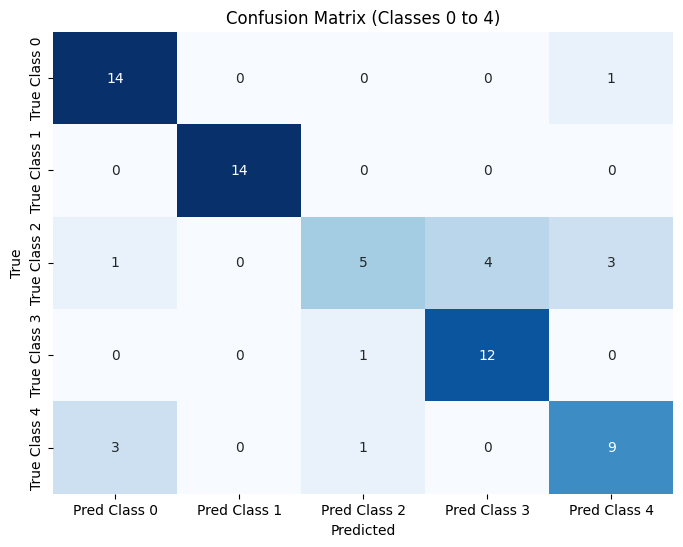


✅ Final MLP Accuracy: 0.7941

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       1.00      1.00      1.00        14
           2       0.71      0.38      0.50        13
           3       0.75      0.92      0.83        13
           4       0.69      0.69      0.69        13

    accuracy                           0.79        68
   macro avg       0.79      0.79      0.77        68
weighted avg       0.79      0.79      0.78        68



['scaler_optuna_best_relu.pkl']

In [6]:
import pandas as pd
import joblib
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("transformed_land_mines.csv")
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Optuna objective function with pruning
def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical(
        "hidden_layer_sizes", [(128, 128), (256, 128), (256, 128), (256, 128, 64), (256, 128, 64)]
    )
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 2e-4, 1e-1, log=True)
    max_iter = trial.suggest_int("max_iter", 300, 800)

    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation="relu",
        solver="adam",
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Report intermediate accuracy and prune if necessary
    trial.report(accuracy, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return accuracy

# Run Optuna study with pruning
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100, timeout=600)  # Add timeout or other limits if needed

# Print best params
print("🔧 Best Hyperparameters:")
print(study.best_params)
print(f"🏆 Best Accuracy: {study.best_value:.4f}")

# Train final model
best_params = study.best_params
final_model = MLPClassifier(
    **best_params,
    activation="relu",
    solver="adam",
    random_state=42
)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn for classes 0 to 4
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=[f'Pred Class {i}' for i in range(5)], 
            yticklabels=[f'True Class {i}' for i in range(5)])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Classes 0 to 4)')
plt.show()

print(f"\n✅ Final MLP Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📊 Classification Report:\n{classification_report(y_test, y_pred)}")

# Save model and scaler
joblib.dump(final_model, "mlp_optuna_best_relu.pkl")
joblib.dump(scaler, "scaler_optuna_best_relu.pkl")


✅ Final MLP Accuracy: 0.7941

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       1.00      1.00      1.00        14
           2       0.71      0.38      0.50        13
           3       0.75      0.92      0.83        13
           4       0.69      0.69      0.69        13

    accuracy                           0.79        68
   macro avg       0.79      0.79      0.77        68
weighted avg       0.79      0.79      0.78        68



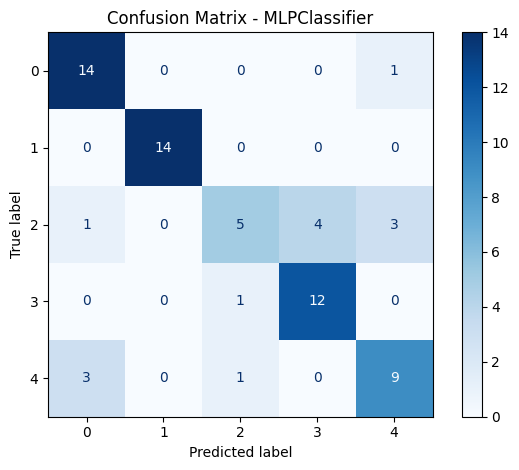

['scaler_optuna_best_relu.pkl']

In [8]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare features and labels
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Shift labels from 1–5 to 0–4

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Define and train the final MLP model
clf = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    alpha=1.5533844813198423e-05,
    learning_rate_init=0.012213599390700235,
    max_iter=587,
    activation="relu",
    solver="adam",
    random_state=42
)

clf.fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Final MLP Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, display_labels=[0, 1, 2, 3, 4], cmap="Blues"
)
plt.title("Confusion Matrix - MLPClassifier")
plt.tight_layout()
plt.show()

# Save model and scaler
joblib.dump(clf, "mlp_optuna_best_relu.pkl")
joblib.dump(scaler, "scaler_optuna_best_relu.pkl")


/workspaces/FDS_MiniProject/fds/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-15 18:39:56,699] A new study created in memory with name: no-name-5a77544c-e4e2-4d25-a94a-b7a8a0ff57ea
/workspaces/FDS_MiniProject/fds/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 256) which is of type tuple.
  warnings.warn(message)
/workspaces/FDS_MiniProject/fds/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (512, 256) which is of type tuple.
  warnings.warn(message)
/workspaces/FDS_MiniProject/fds/lib/pyth

🔧 Best Hyperparameters:
{'hidden_layer_sizes': (512, 256), 'alpha': 0.002216037633793225, 'learning_rate_init': 0.020868678135528246, 'max_iter': 567}
🏆 Best Accuracy: 0.7647


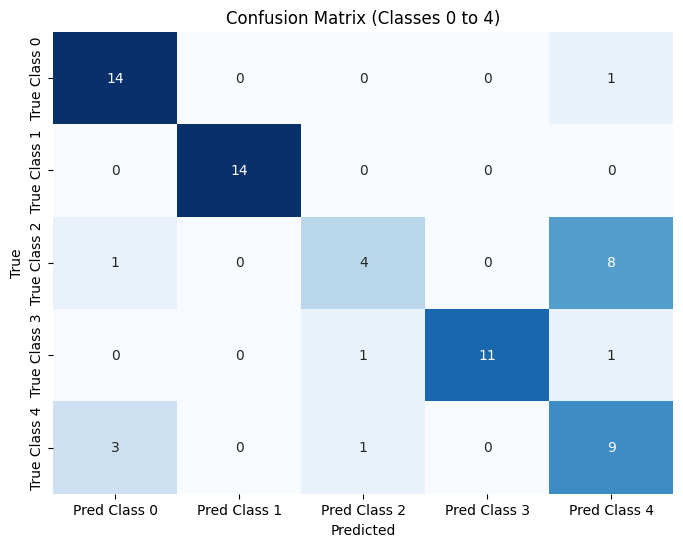


✅ Final MLP Accuracy: 0.7647

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       1.00      1.00      1.00        14
           2       0.67      0.31      0.42        13
           3       1.00      0.85      0.92        13
           4       0.47      0.69      0.56        13

    accuracy                           0.76        68
   macro avg       0.78      0.76      0.75        68
weighted avg       0.79      0.76      0.76        68



['scaler_optuna_best_relu.pkl']

In [1]:
import pandas as pd
import joblib
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("transformed_land_mines.csv")
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Optuna objective function with pruning
def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical(
        "hidden_layer_sizes", [(256, 256), (512, 256), (512, 256), (512, 256, 128), (512, 256, 128)]
    )
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 2e-4, 1e-1, log=True)
    max_iter = trial.suggest_int("max_iter", 300, 800)

    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation="relu",
        solver="adam",
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Report intermediate accuracy and prune if necessary
    trial.report(accuracy, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return accuracy

# Run Optuna study with pruning
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100, timeout=600)  # Add timeout or other limits if needed

# Print best params
print("🔧 Best Hyperparameters:")
print(study.best_params)
print(f"🏆 Best Accuracy: {study.best_value:.4f}")

# Train final model
best_params = study.best_params
final_model = MLPClassifier(
    **best_params,
    activation="relu",
    solver="adam",
    random_state=42
)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn for classes 0 to 4
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=[f'Pred Class {i}' for i in range(5)], 
            yticklabels=[f'True Class {i}' for i in range(5)])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Classes 0 to 4)')
plt.show()

print(f"\n✅ Final MLP Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📊 Classification Report:\n{classification_report(y_test, y_pred)}")

# Save model and scaler
joblib.dump(final_model, "mlp_optuna_best_relu.pkl")
joblib.dump(scaler, "scaler_optuna_best_relu.pkl")
